# 영주시 날씨에 따른 사과 가격 예측 - LSTM

##### 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split


##### 데이터 불러오기

In [52]:
df_1 = pd.read_excel('./back_data_평균가격.xlsx')
df_1

,최저기온(°C),최고기온(°C),강수량,최대 풍속(m/s),최다풍향,평균 이슬점온도(°C),평균 상대습도(%),평균 현지기압(hPa),평균가격(원)
0,-4.8,4.0,3.328571,8.0,290.0,-5.1,65.6,1002.4,23825.000000
1,-1.9,5.3,3.971429,7.2,290.0,-6.9,52.9,999.3,20758.489360
2,-6.3,5.7,4.614286,6.8,290.0,-6.5,61.4,999.0,29777.616742
3,-4.6,3.7,5.900000,2.7,320.0,-2.1,81.3,1002.0,28609.448045
4,3.0,9.4,58.400000,3.4,320.0,6.5,100.0,987.1,28631.750371
...,...,...,...,...,...,...,...,...,...
1270,-0.6,7.1,0.700000,9.7,290.0,-7.7,50.3,990.6,88017.406893
1271,-2.9,7.4,0.700000,6.4,290.0,-9.6,44.1,997.2,90588.023414
1272,-2.4,10.4,0.700000,2.7,320.0,-4.3,58.1,994.9,95224.193359
1273,-1.4,10.6,0.000000,4.3,320.0,-0.4,77.1,989.6,87635.755649


In [53]:
df_1_max = df_1['평균가격(원)'].max()
df_1_min = df_1['평균가격(원)'].min()

In [54]:
df_2 = pd.read_excel('./back_data_총거래물량.xlsx')
df_2

,최저기온(°C),최고기온(°C),강수량,최대 풍속(m/s),최다풍향,평균 이슬점온도(°C),평균 상대습도(%),평균 현지기압(hPa),총거래물량(kg)
0,-4.8,4.0,3.328571,8.0,290.0,-5.1,65.6,1002.4,1200.0
1,-1.9,5.3,3.971429,7.2,290.0,-6.9,52.9,999.3,69636.0
2,-6.3,5.7,4.614286,6.8,290.0,-6.5,61.4,999.0,81055.0
3,-4.6,3.7,5.900000,2.7,320.0,-2.1,81.3,1002.0,202560.0
4,3.0,9.4,58.400000,3.4,320.0,6.5,100.0,987.1,144105.0
...,...,...,...,...,...,...,...,...,...
1270,-0.6,7.1,0.700000,9.7,290.0,-7.7,50.3,990.6,50820.0
1271,-2.9,7.4,0.700000,6.4,290.0,-9.6,44.1,997.2,6520.0
1272,-2.4,10.4,0.700000,2.7,320.0,-4.3,58.1,994.9,78590.0
1273,-1.4,10.6,0.000000,4.3,320.0,-0.4,77.1,989.6,74070.0


In [55]:
df_2_max = df_2['총거래물량(kg)'].max() 
df_2_min = df_2['총거래물량(kg)'].min()

In [56]:
df_3 = pd.read_excel('./back_data_총거래금액.xlsx')
df_3

,최저기온(°C),최고기온(°C),강수량,최대 풍속(m/s),최다풍향,평균 이슬점온도(°C),평균 상대습도(%),평균 현지기압(hPa),총거래금액(원)
0,-4.8,4.0,3.328571,8.0,290.0,-5.1,65.6,1002.4,2859000
1,-1.9,5.3,3.971429,7.2,290.0,-6.9,52.9,999.3,159041400
2,-6.3,5.7,4.614286,6.8,290.0,-6.5,61.4,999.0,140294100
3,-4.6,3.7,5.900000,2.7,320.0,-2.1,81.3,1002.0,459338400
4,3.0,9.4,58.400000,3.4,320.0,6.5,100.0,987.1,309839600
...,...,...,...,...,...,...,...,...,...
1270,-0.6,7.1,0.700000,9.7,290.0,-7.7,50.3,990.6,239655700
1271,-2.9,7.4,0.700000,6.4,290.0,-9.6,44.1,997.2,29052800
1272,-2.4,10.4,0.700000,2.7,320.0,-4.3,58.1,994.9,411866200
1273,-1.4,10.6,0.000000,4.3,320.0,-0.4,77.1,989.6,375004900


In [57]:
df_3_max = df_3['총거래금액(원)'].max()
df_3_min = df_3['총거래금액(원)'].min()

##### 2024-03-13 예측하기 위해 마지막 컬럼 제거

In [65]:
test = df_1.iloc[-1,:]
test

최저기온(°C)            -3.90000
최고기온(°C)            12.10000
강수량                  0.00000
최대 풍속(m/s)           7.40000
최다풍향               290.00000
평균 이슬점온도(°C)        -4.50000
평균 상대습도(%)          58.60000
평균 현지기압(hPa)       994.10000
평균가격(원)         106097.84881
Name: 1274, dtype: float64

In [66]:
df_1 = df_1.iloc[:-1]
df_1

,최저기온(°C),최고기온(°C),강수량,최대 풍속(m/s),최다풍향,평균 이슬점온도(°C),평균 상대습도(%),평균 현지기압(hPa),평균가격(원)
0,-4.8,4.0,3.328571,8.0,290.0,-5.1,65.6,1002.4,23825.000000
1,-1.9,5.3,3.971429,7.2,290.0,-6.9,52.9,999.3,20758.489360
2,-6.3,5.7,4.614286,6.8,290.0,-6.5,61.4,999.0,29777.616742
3,-4.6,3.7,5.900000,2.7,320.0,-2.1,81.3,1002.0,28609.448045
4,3.0,9.4,58.400000,3.4,320.0,6.5,100.0,987.1,28631.750371
...,...,...,...,...,...,...,...,...,...
1269,1.0,5.2,0.700000,8.4,320.0,-1.8,73.8,991.4,89017.336423
1270,-0.6,7.1,0.700000,9.7,290.0,-7.7,50.3,990.6,88017.406893
1271,-2.9,7.4,0.700000,6.4,290.0,-9.6,44.1,997.2,90588.023414
1272,-2.4,10.4,0.700000,2.7,320.0,-4.3,58.1,994.9,95224.193359


In [67]:
df_2 = df_2.iloc[:-1]
df_2

,최저기온(°C),최고기온(°C),강수량,최대 풍속(m/s),최다풍향,평균 이슬점온도(°C),평균 상대습도(%),평균 현지기압(hPa),총거래물량(kg)
0,-4.8,4.0,3.328571,8.0,290.0,-5.1,65.6,1002.4,1200.0
1,-1.9,5.3,3.971429,7.2,290.0,-6.9,52.9,999.3,69636.0
2,-6.3,5.7,4.614286,6.8,290.0,-6.5,61.4,999.0,81055.0
3,-4.6,3.7,5.900000,2.7,320.0,-2.1,81.3,1002.0,202560.0
4,3.0,9.4,58.400000,3.4,320.0,6.5,100.0,987.1,144105.0
...,...,...,...,...,...,...,...,...,...
1269,1.0,5.2,0.700000,8.4,320.0,-1.8,73.8,991.4,45830.0
1270,-0.6,7.1,0.700000,9.7,290.0,-7.7,50.3,990.6,50820.0
1271,-2.9,7.4,0.700000,6.4,290.0,-9.6,44.1,997.2,6520.0
1272,-2.4,10.4,0.700000,2.7,320.0,-4.3,58.1,994.9,78590.0


In [16]:
df_3 = df_3.iloc[:-1]
df_3

,최저기온(°C),최고기온(°C),강수량,최대 풍속(m/s),최다풍향,평균 이슬점온도(°C),평균 상대습도(%),평균 현지기압(hPa),총거래금액(원)
0,-4.8,4.0,3.328571,8.0,290.0,-5.1,65.6,1002.4,2859000
1,-1.9,5.3,3.971429,7.2,290.0,-6.9,52.9,999.3,159041400
2,-6.3,5.7,4.614286,6.8,290.0,-6.5,61.4,999.0,140294100
3,-4.6,3.7,5.900000,2.7,320.0,-2.1,81.3,1002.0,459338400
4,3.0,9.4,58.400000,3.4,320.0,6.5,100.0,987.1,309839600
...,...,...,...,...,...,...,...,...,...
1269,1.0,5.2,0.700000,8.4,320.0,-1.8,73.8,991.4,232185400
1270,-0.6,7.1,0.700000,9.7,290.0,-7.7,50.3,990.6,239655700
1271,-2.9,7.4,0.700000,6.4,290.0,-9.6,44.1,997.2,29052800
1272,-2.4,10.4,0.700000,2.7,320.0,-4.3,58.1,994.9,411866200


##### 스케일링

In [68]:
#컬럼 선택
features_1 = ['최저기온(°C)', '최고기온(°C)', '강수량', '최대 풍속(m/s)',
         '최다풍향', '평균 이슬점온도(°C)', '평균 상대습도(%)', '평균 현지기압(hPa)', 
        '평균가격(원)']

features_2 = ['최저기온(°C)', '최고기온(°C)', '강수량', '최대 풍속(m/s)',
         '최다풍향', '평균 이슬점온도(°C)', '평균 상대습도(%)', '평균 현지기압(hPa)', 
        '총거래물량(kg)']

features_3 = ['최저기온(°C)', '최고기온(°C)', '강수량', '최대 풍속(m/s)',
         '최다풍향', '평균 이슬점온도(°C)', '평균 상대습도(%)', '평균 현지기압(hPa)', 
        '총거래금액(원)']

# 데이터 정규화
scaler = MinMaxScaler()
df_1[features_1] = scaler.fit_transform(df_1[features_1])
df_2[features_2] = scaler.fit_transform(df_2[features_2])
df_3[features_3] = scaler.fit_transform(df_3[features_3])

##### LSTM 입력 데이터 생성

In [69]:
def create_dataset(df, time_steps, features):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df.iloc[i:(i + time_steps)][features[:-1]].values) # 마지막 열을 제외한 모든 열을 X에 추가
        y.append(df.iloc[i + time_steps][features[-1]])
    return np.array(X), np.array(y)

time_steps = 7 # 시계열 길이 설정 ( 조정 가능)

### df_1 모델

In [82]:
X.shape

(1268, 7, 8)

In [91]:
# df_1

X, y = create_dataset(df_1, time_steps, features_1)

# 데이터 셋 분할 (학습, 검증, 테스트)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# LSTM 모델 생성
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'),
    # Dropout(rate=0.5),  # Dropout 추가
    # LSTM(units=50, return_sequences=True, activation='tanh'),  # 두 번째 LSTM 층
    # Dropout(rate=0.5),  # Dropout 추가
    LSTM(units=64,activation='tanh'),  # 세 번째 LSTM 층 (마지막 층이므로 return_sequences=False로 설정)
    # Dropout(rate=0.5),  # Dropout 추가
    Dense(25, activation='relu'),  # 은닉층
    # BatchNormalization(),  # 배치 정규화
    Dense(1)  # 출력층
])

# 모델 컴파일 (손실 함수로 MSE 사용)
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# 모델 평가
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

Epoch 1/10
28/28 [==============================] - 5s 37ms/step - loss: 0.0966 - mse: 0.0153 - val_loss: 0.1147 - val_mse: 0.0325
Epoch 2/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0876 - mse: 0.0127 - val_loss: 0.1224 - val_mse: 0.0367
Epoch 3/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0858 - mse: 0.0127 - val_loss: 0.1289 - val_mse: 0.0393
Epoch 4/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0862 - mse: 0.0124 - val_loss: 0.1101 - val_mse: 0.0286
Epoch 5/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0889 - mse: 0.0131 - val_loss: 0.1354 - val_mse: 0.0429
Epoch 6/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0859 - mse: 0.0124 - val_loss: 0.1215 - val_mse: 0.0355
Epoch 7/10
28/28 [==============================] - 0s 10ms/step - loss: 0.0847 - mse: 0.0121 - val_loss: 0.1339 - val_mse: 0.0417
Epoch 8/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0841 - mse: 0.

In [71]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 7, 50)             11800     
                                                                 
 dropout_12 (Dropout)        (None, 7, 50)             0         
                                                                 
 lstm_13 (LSTM)              (None, 7, 50)             20200     
                                                                 
 dropout_13 (Dropout)        (None, 7, 50)             0         
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_14 (Dropout)        (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [72]:
##### 2024-03-13 사과 평균가격 예측

In [92]:
last_sequence = df_1.iloc[-time_steps:][features_1[:-1]].values
last_sequence = np.expand_dims(last_sequence, axis=0)
predicted_value = model.predict(last_sequence)
## 원래의 값 = (정규화된 값 * (max - min)) + min
predicted_value = (predicted_value * (df_1_max - df_1_min)) + df_1_min
print(f"2024년 3월 13일 사과 평균가격 예측 : {predicted_value}")

1/1 [==============================] - 1s 648ms/step
2024년 3월 13일 사과 평균가격 예측 : [[35428.137]]


In [93]:
# 일반적인 숫자 형식으로 변환
number_in_standard_form = np.format_float_positional(predicted_value)

print(number_in_standard_form)

35428.13671875


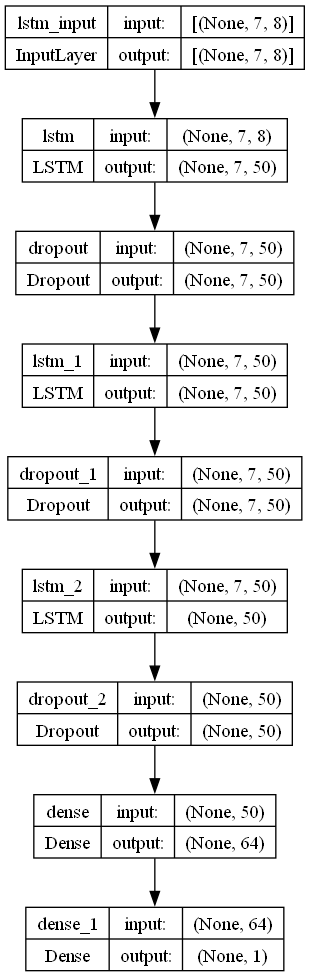

In [17]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

### df_2 모델  

In [87]:
# df_2

X, y = create_dataset(df_2, time_steps, features_2)

# 데이터 셋 분할 (학습, 검증, 테스트)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# LSTM 모델 생성
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'),
    # Dropout(rate=0.5),  # Dropout 추가
    LSTM(units=64, activation='tanh'),  # 두 번째 LSTM 층
    # Dropout(rate=0.5),  # Dropout 추가
    # LSTM(units=50,activation='tanh'),  # 세 번째 LSTM 층 (마지막 층이므로 return_sequences=False로 설정)
    # Dropout(rate=0.5),  # Dropout 추가
    Dense(25, activation='relu'),  # 은닉층
    # BatchNormalization(),  # 배치 정규화
    Dense(1)  # 출력층
])

# 모델 컴파일 (손실 함수로 MSE 사용)
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# 모델 평가
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

Epoch 1/10
28/28 [==============================] - 4s 37ms/step - loss: 0.1260 - mse: 0.0302 - val_loss: 0.0948 - val_mse: 0.0150
Epoch 2/10
28/28 [==============================] - 0s 7ms/step - loss: 0.1139 - mse: 0.0246 - val_loss: 0.0782 - val_mse: 0.0136
Epoch 3/10
28/28 [==============================] - 0s 7ms/step - loss: 0.1130 - mse: 0.0245 - val_loss: 0.0848 - val_mse: 0.0137
Epoch 4/10
28/28 [==============================] - 0s 7ms/step - loss: 0.1139 - mse: 0.0240 - val_loss: 0.0982 - val_mse: 0.0158
Epoch 5/10
28/28 [==============================] - 0s 7ms/step - loss: 0.1128 - mse: 0.0243 - val_loss: 0.0821 - val_mse: 0.0134
Epoch 6/10
28/28 [==============================] - 0s 7ms/step - loss: 0.1100 - mse: 0.0234 - val_loss: 0.0826 - val_mse: 0.0136
Epoch 7/10
28/28 [==============================] - 0s 7ms/step - loss: 0.1093 - mse: 0.0232 - val_loss: 0.0888 - val_mse: 0.0147
Test Loss: [0.11330991983413696, 0.019559040665626526]


In [88]:
##### 2024-03-13 사과 총거래물량 예측

In [89]:
last_sequence = df_2.iloc[-time_steps:][features_2[:-1]].values
last_sequence = np.expand_dims(last_sequence, axis=0)
predicted_value = model.predict(last_sequence)
## 원래의 값 = (정규화된 값 * (max - min)) + min
predicted_value = (predicted_value * (df_2_max - df_2_min)) + df_2_min
print(f"2024년 3월 13일 사과 총거래물량 예측 : {predicted_value}")

1/1 [==============================] - 1s 658ms/step
2024년 3월 13일 사과 총거래물량 예측 : [[64088.71]]


In [90]:
# 일반적인 숫자 형식으로 변환
number_in_standard_form = np.format_float_positional(predicted_value)

print(number_in_standard_form)

64088.7109375


### df_3 모델

In [94]:
# df_3

X, y = create_dataset(df_3, time_steps, features_3)

# 데이터 셋 분할 (학습, 검증, 테스트)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# LSTM 모델 생성
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'),
    # Dropout(rate=0.5),  # Dropout 추가
    # LSTM(units=50, return_sequences=True, activation='tanh'),  # 두 번째 LSTM 층
    # Dropout(rate=0.5),  # Dropout 추가
    LSTM(units=64,activation='tanh'),  # 세 번째 LSTM 층 (마지막 층이므로 return_sequences=False로 설정)
    # Dropout(rate=0.5),  # Dropout 추가
    Dense(25, activation='relu'),  # 은닉층
    # BatchNormalization(),  # 배치 정규화
    Dense(1)  # 출력층
])

# 모델 컴파일 (손실 함수로 MSE 사용)
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# 모델 평가
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

Epoch 1/10
28/28 [==============================] - 4s 35ms/step - loss: 0.0966 - mse: 0.0232 - val_loss: 0.0563 - val_mse: 0.0081
Epoch 2/10
28/28 [==============================] - 0s 7ms/step - loss: 0.0928 - mse: 0.0215 - val_loss: 0.0587 - val_mse: 0.0081
Epoch 3/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0886 - mse: 0.0210 - val_loss: 0.0557 - val_mse: 0.0080
Epoch 4/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0887 - mse: 0.0204 - val_loss: 0.0582 - val_mse: 0.0079
Epoch 5/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0880 - mse: 0.0208 - val_loss: 0.0595 - val_mse: 0.0082
Epoch 6/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0876 - mse: 0.0203 - val_loss: 0.0583 - val_mse: 0.0079
Epoch 7/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0870 - mse: 0.0200 - val_loss: 0.0570 - val_mse: 0.0082
Epoch 8/10
28/28 [==============================] - 0s 8ms/step - loss: 0.0869 - mse: 0.0

In [ ]:
##### 2024-03-13 사과 총거래물량 예측

In [95]:
last_sequence = df_2.iloc[-time_steps:][features_2[:-1]].values
last_sequence = np.expand_dims(last_sequence, axis=0)
predicted_value = model.predict(last_sequence)
## 원래의 값 = (정규화된 값 * (max - min)) + min
predicted_value = (predicted_value * (df_3_max - df_3_min)) + df_3_min
print(f"2024년 3월 13일 사과 총 거래금액 예측 : {predicted_value}")

1/1 [==============================] - 1s 643ms/step
2024년 3월 13일 사과 총 거래금액 예측 : [[1.64789414e+08]]


In [96]:
# 일반적인 숫자 형식으로 변환
number_in_standard_form = np.format_float_positional(predicted_value)

print(number_in_standard_form)

164789413.82441372


### 타겟을 평균가격, 총거래물량, 총거래금액 3 개로 각각 모두 테스트 한 결과, 총거래물량을 타겟으로 두었을 때, 예측을 제일 잘했다!